In [1]:
!pip install yfinance statsmodels


In [23]:
#imports & parameters
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

#Strategy parameters
tickers = ['PEP', 'KO']
start_date = '2018-01-01'
end_date = None
entry_z = 2.0              #z-score to enter a position
exit_z = 0.5               #z-score to exit a position
commission = 0.0005        #commission per dollar traded
min_lookback = 5
max_lookback = 60


In [24]:
#Downloading historical price data for the tickers
data = yf.download(tickers, start=start_date, end=end_date, progress=False)

#Using 'Adj Close' if available, otherwise fall back to 'Close'. I was getting errors only running the above in this cell since the data is
#constantly changing
if 'Adj Close' in data.columns:
    data = data['Adj Close']
else:
    data = data['Close']

#Dropping missing values (if any)
data = data.dropna()

#Displaying the first few rows
data.head()




/tmp/ipython-input-1762403758.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date, progress=False)


Ticker,KO,PEP
Date,,
2018-01-02,35.742027,93.325165
2018-01-03,35.663536,93.080109
2018-01-04,36.165855,93.538589
2018-01-05,36.158005,93.807358
2018-01-08,36.103050,93.269798


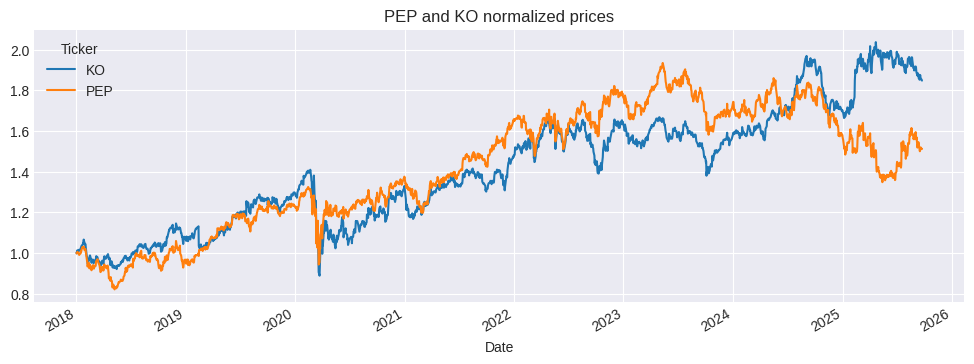

In [25]:
#normalize plot to visualize pair behaviour
(df_norm := data / data.iloc[0]).plot(figsize=(12,4), title='PEP and KO normalized prices')
plt.show()




In [27]:
#cointegration test
pep = data['PEP']
ko = data['KO']

coint_t, pvalue, crit_vals = coint(pep, ko)
print(f"Cointegration test p-value = {pvalue:.4f}; t-stat = {coint_t:.4f}")
print("Critical values:", dict(zip(['1%','5%','10%'], crit_vals)))

Cointegration test p-value = 0.8569; t-stat = -1.2036
Critical values: {'1%': np.float64(-3.9020912998738417), '5%': np.float64(-3.3392797244710724), '10%': np.float64(-3.0466357812156186)}


In [28]:
#hedge ratio via OLS (Pep = alpha + beta * Ko + eps)
X = sm.add_constant(ko)
ols_res = sm.OLS(pep, X).fit()
alpha, beta = ols_res.params['const'], ols_res.params['KO']
print(f"Hedge ratio (beta) from OLS: {beta:.6f}; intercept (alpha): {alpha:.6f}")


Hedge ratio (beta) from OLS: 2.160539; intercept (alpha): 23.371192


In [29]:
#spread and half-life calculation
spread = pep - beta * ko

#half-life of mean reversion (AR(1) method)
spread_lag = spread.shift(1)
delta = spread - spread_lag
#align
valid = delta.dropna().index
delta = delta.loc[valid]
spread_lag = spread_lag.loc[valid]

hl_reg = sm.OLS(delta.values, sm.add_constant(spread_lag.values)).fit()
gamma = hl_reg.params[1]
phi = gamma + 1.0
if phi <= 0 or phi >= 1:
    half_life = 20
else:
    half_life = -np.log(2) / np.log(phi)

half_life = max(1.0, half_life)
lookback = int(max(min(half_life * 2, max_lookback), min_lookback))
print(f"Estimated half-life = {half_life:.2f} days. Rolling lookback used = {lookback} days.")


Estimated half-life = 313.40 days. Rolling lookback used = 60 days.


In [30]:
#z-score (rolling mean/std)
rolling_mean = spread.rolling(window=lookback).mean()
rolling_std  = spread.rolling(window=lookback).std()
zscore = (spread - rolling_mean) / rolling_std
zscore = zscore.replace([np.inf, -np.inf], np.nan)


In [32]:
#generate signals (stateful)
#rules:
#  - if z > entry_z  -> short the spread (i.e., short PEP, long KO)
#  - if z < -entry_z -> long the spread  (i.e., long PEP, short KO)
#  - if abs(z) < exit_z -> close position
signals = pd.Series(0, index=zscore.index)
pos = 0
for i, t in enumerate(zscore.index):
    z = zscore.iloc[i]
    if np.isnan(z):
        signals.iloc[i] = pos
        continue
    if pos == 0:
        if z > entry_z:
            pos = -1
        elif z < -entry_z:
            pos = 1
    else:
        #if currently in position, exit when absolute z crosses below exit threshold
        if abs(z) < exit_z:
            pos = 0
    signals.iloc[i] = pos

#position in shares: pos_pep = signals * 1 share; pos_ko = signals * (-beta) shares
positions_pep = signals.copy()
positions_ko  = -beta * signals


In [33]:
# backtest P&L
#If we hold (1 * PEP) + (-beta * KO) the portfolio value equals the spread.
#P&L for position = change in spread * position sign.
spread_shift = spread.shift(1)
exposure = (abs(spread_shift.index.map(lambda dt: 0)) if False else (abs(pep.shift(1)) + abs(beta * ko.shift(1))))
#exposure = abs(value of leg1) + abs(value of leg2)
#portfolio P&L in $ (per "1 unit" of the spread positions) = position * (spread_t - spread_{t-1})
pnl = signals.shift(1) * (spread - spread.shift(1))   # P&L realized from holding positions set at previous day
pnl = pnl.fillna(0)

#approximate transaction cost: when we change position, we pay commission on the notional we trade
trade_size = signals.diff().abs().fillna(0)  # 1 for open/close, 2 for reverse (e.g., 1 -> -1)
trade_cost = trade_size.shift(1).fillna(0) * exposure * commission
trade_cost = trade_cost.fillna(0)

pnl_after_cost = pnl - trade_cost

#daily return = pnl_after_cost / exposure (use previous-day exposure)
daily_ret = pnl_after_cost / exposure
daily_ret = daily_ret.replace([np.inf, -np.inf], 0).fillna(0)

#equity curve
equity = (1.0 + daily_ret).cumprod()  #start capital normalized to 1


In [34]:
#performance metrics
days = daily_ret.index.size
annual_factor = 252

cagr = equity.iloc[-1] ** (annual_factor / days) - 1
ann_vol = daily_ret.std() * np.sqrt(annual_factor)
sharpe = cagr / ann_vol if ann_vol != 0 else np.nan
total_trades = int((trade_size > 0).sum())

print(f"CAGR (approx): {cagr:.2%}")
print(f"Annualized volatility: {ann_vol:.2%}")
print(f"Sharpe (rf=0): {sharpe:.2f}")
print(f"Total trade events (open/close): {total_trades}")


CAGR (approx): -2.00%
Annualized volatility: 6.33%
Sharpe (rf=0): -0.32
Total trade events (open/close): 61


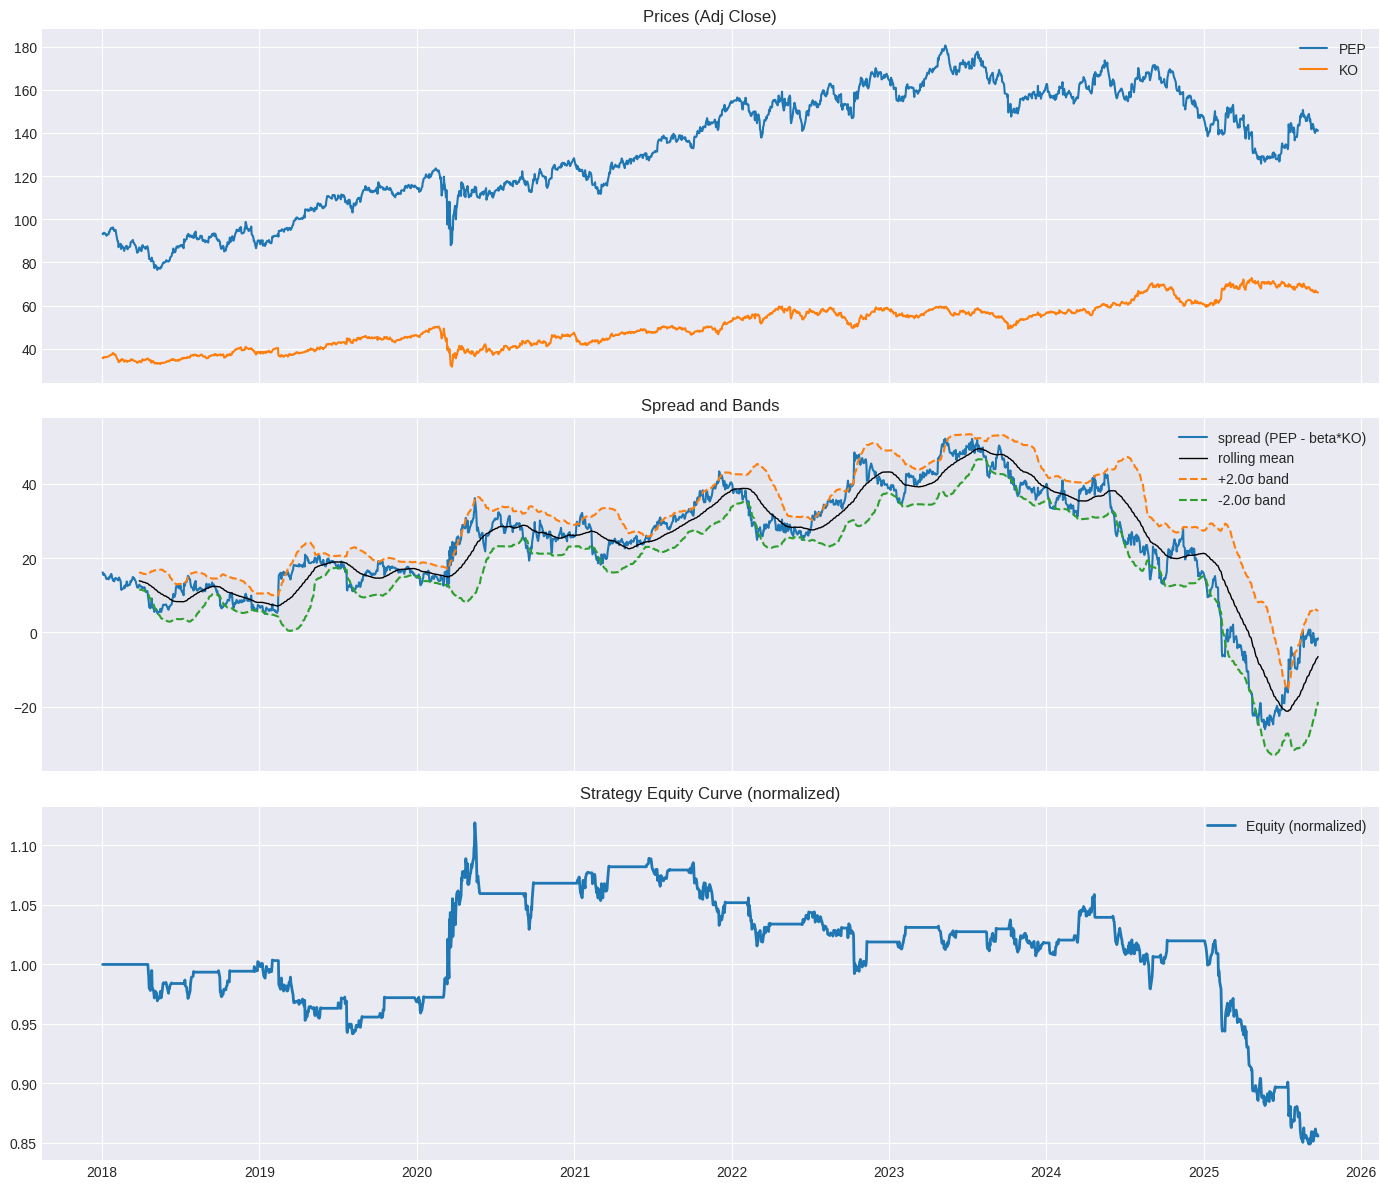

In [35]:
# plots: spread + zscore bands, and equity curve
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

#prices
axes[0].plot(pep.index, pep, label='PEP')
axes[0].plot(ko.index, ko, label='KO')
axes[0].set_title('Prices (Adj Close)')
axes[0].legend()

#spread and bands
axes[1].plot(spread.index, spread, label='spread (PEP - beta*KO)')
axes[1].plot(rolling_mean.index, rolling_mean, color='black', lw=1, label='rolling mean')
axes[1].plot(rolling_mean.index, rolling_mean + entry_z * rolling_std, '--', label=f'+{entry_z}σ band')
axes[1].plot(rolling_mean.index, rolling_mean - entry_z * rolling_std, '--', label=f'-{entry_z}σ band')
axes[1].fill_between(spread.index, rolling_mean - entry_z * rolling_std, rolling_mean + entry_z * rolling_std, color='gray', alpha=0.06)
axes[1].set_title('Spread and Bands')
axes[1].legend()

#equity
axes[2].plot(equity.index, equity, lw=2, label='Equity (normalized)')
axes[2].set_title('Strategy Equity Curve (normalized)')
axes[2].legend()

plt.tight_layout()
plt.show()


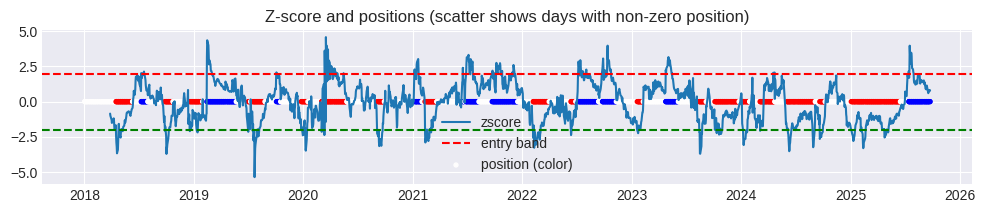

In [36]:
#showing periods where we held position
holding = signals.copy()
holding[holding == 0] = np.nan
plt.figure(figsize=(12,2))
plt.plot(zscore.index, zscore, label='zscore')
plt.axhline(entry_z, color='red', linestyle='--', label='entry band')
plt.axhline(-entry_z, color='green', linestyle='--')
plt.scatter(holding.index, np.zeros(len(holding)), c=signals, cmap='bwr', s=8, label='position (color)')
plt.title('Z-score and positions (scatter shows days with non-zero position)')
plt.legend()
plt.show()
